### Preprocesamiento

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import StemmerTokenizer, make_BoW_preprocess

tokenizador = StemmerTokenizer()
preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=1,min_ngram=1,mindf=5)

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline

bog_pipeline = Pipeline(
    [("Preprocessing", preprocessing),
    # ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", MultinomialNB())]
)

### Cargar datos

In [3]:
from utils.cargar import df_caso
from utils.preprocesamiento import process_df

caso = 'adela'
df = df_caso(caso)

df = process_df(df,'comment','sel',verbose=True)

df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

df.head()

79 rows found with non string elements for column comment (1.02%)
Deleting 1059 columns for which max target value is over 7 (13.72%)
6579 available rows after processing


,sel,comment
id,,
20277,4,hola
20278,6,No
20283,1,Eres un monstruo maldita
20285,6,Hola
20291,5,porque sí


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df, df['sel'], test_size=.25, stratify=df['sel'], random_state=0)

In [5]:
bog_pipeline.fit(df_train,y_train)

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=5,
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f4242acecd0>),
                                                  'comment')])),
                ('Clasificador', MultinomialNB())])

In [6]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)

print("Resultados clasificador Naive-Bayes multinomial")
print(classification_report(y_test, y_pred))

Resultados clasificador Naive-Bayes multinomial
              precision    recall  f1-score   support

           1       0.37      0.20      0.26       203
           2       0.57      0.66      0.61       629
           3       0.45      0.43      0.44       406
           4       0.26      0.30      0.28       221
           5       0.25      0.27      0.26       142
           6       0.14      0.05      0.07        44

    accuracy                           0.45      1645
   macro avg       0.34      0.32      0.32      1645
weighted avg       0.43      0.45      0.44      1645



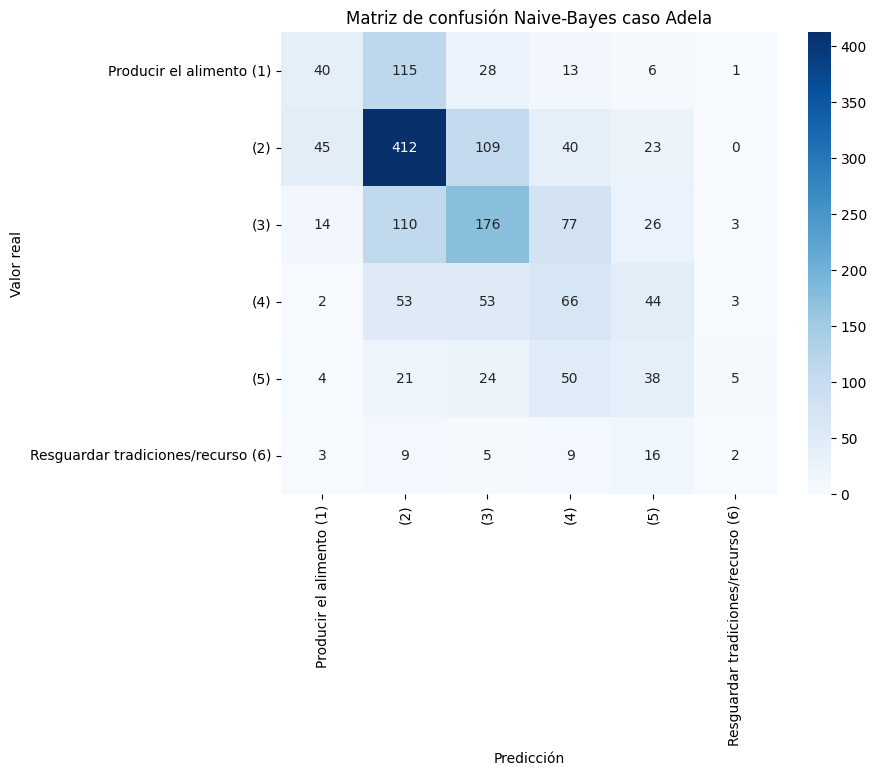

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Example class labels
class_labels = ['Producir el alimento (1)', '(2)', '(3)', '(4)', '(5)', 'Resguardar tradiciones/recurso (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión Naive-Bayes caso Adela')

# Show the plot
plt.show()

In [8]:
df.loc[(df['sel']==2) | (df['sel']==3),'sel'] = 1
df.loc[(df['sel']==4) | (df['sel']==5),'sel'] = 6

df.head()

,sel,comment
id,,
20277,6,hola
20278,6,No
20283,1,Eres un monstruo maldita
20285,6,Hola
20291,6,porque sí


In [9]:
df['sel'].value_counts()

1    4954
6    1625
Name: sel, dtype: int64

In [10]:
df_train_binary, df_test_binary, y_train_binary, y_test_binary = train_test_split(df, df['sel'], test_size=.25, stratify=df['sel'], random_state=0)

preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=5)

bog_pipeline_binary = Pipeline(
    [("Preprocessing", preprocessing),
    # ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", MultinomialNB())]
)

bog_pipeline_binary.fit(df_train_binary,y_train_binary)

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f4242acecd0>),
                                                  'comment')])),
                ('Clasificador', MultinomialNB())])

In [11]:
y_pred_binary = bog_pipeline_binary.predict(df_test_binary)

print("Resultados clasificador Naive-Bayes multinomial (binario)")
print(classification_report(y_test_binary, y_pred_binary))

Resultados clasificador Naive-Bayes multinomial (binario)
              precision    recall  f1-score   support

           1       0.90      0.80      0.85      1239
           6       0.54      0.72      0.62       406

    accuracy                           0.78      1645
   macro avg       0.72      0.76      0.73      1645
weighted avg       0.81      0.78      0.79      1645



### Probabilidad por palabra/n_grama en Naive-Bayes

Comenzamos por extraer el vectorizador

In [12]:
vectorizer = bog_pipeline.named_steps['Preprocessing'].transformers_[0][1]
vectorizer

CountVectorizer(min_df=5,
                tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f42281020a0>)

In [13]:
from NB_utils import get_probs, get_top_k_ngrams

prob_1, prob_6 = [], []

for ngram in vectorizer.get_feature_names_out():
    probs = get_probs(ngram,bog_pipeline_binary,df_test_binary,'comment')
    prob_1.append(probs[0])
    prob_6.append(probs[1])


op_left, op_right = 'Producir el alimento', 'Resguardar tradiciones/recurso'

get_top_k_ngrams(10,vectorizer,prob_1,prob_6,op_left,op_right);

Top features 'Producir el alimento':
agot 0.9830627187258467
entiend 0.9525869452259099
poblador 0.9499375662928145
dispon 0.9499375662928145
agrav 0.9484986526286152
renov 0.9453575437736446
usa 0.9436387857388706
animal 0.9436387857388706
natural 0.9417137447493205
faun 0.9411715498608155

Top features 'Resguardar tradiciones/recurso':
incomod 0.9078769154024557
volunt 0.8775605704024604
profesional 0.8431490091536257
sigl 0.8175037543747645
ancestral 0.7850649456604233
conform 0.7666285431343413
irrespetu 0.7288311250325876
interrump 0.7288311250325876
exact 0.6913372937962395
masific 0.6764239476377468
